In [98]:
import networkx as nx # type: ignore
from tqdm import tqdm # type: ignore
import igraph as ig
import random
import time

%run toy_city_generation.ipynb
%run city_utilities.ipynb
%run real_city_generation.ipynb

%pip install osmnx matplotlib igraph

Note: you may need to restart the kernel to use updated packages.


Getting graph...
Graph loaded from 'nyc_roads.graphml'
Getting zones...
Assigning zones to nodes...
Fabricating trips...
Fabricating trip 0
Fabricating trip 1
Fabricating trip 2
Fabricating trip 3
Fabricating trip 4
Fabricating trip 5
Fabricating trip 6
Fabricating trip 7
Fabricating trip 8
Fabricating trip 9
Visualising real city...
Map saved as 'nyc_roads_map_with_valid_points.png'


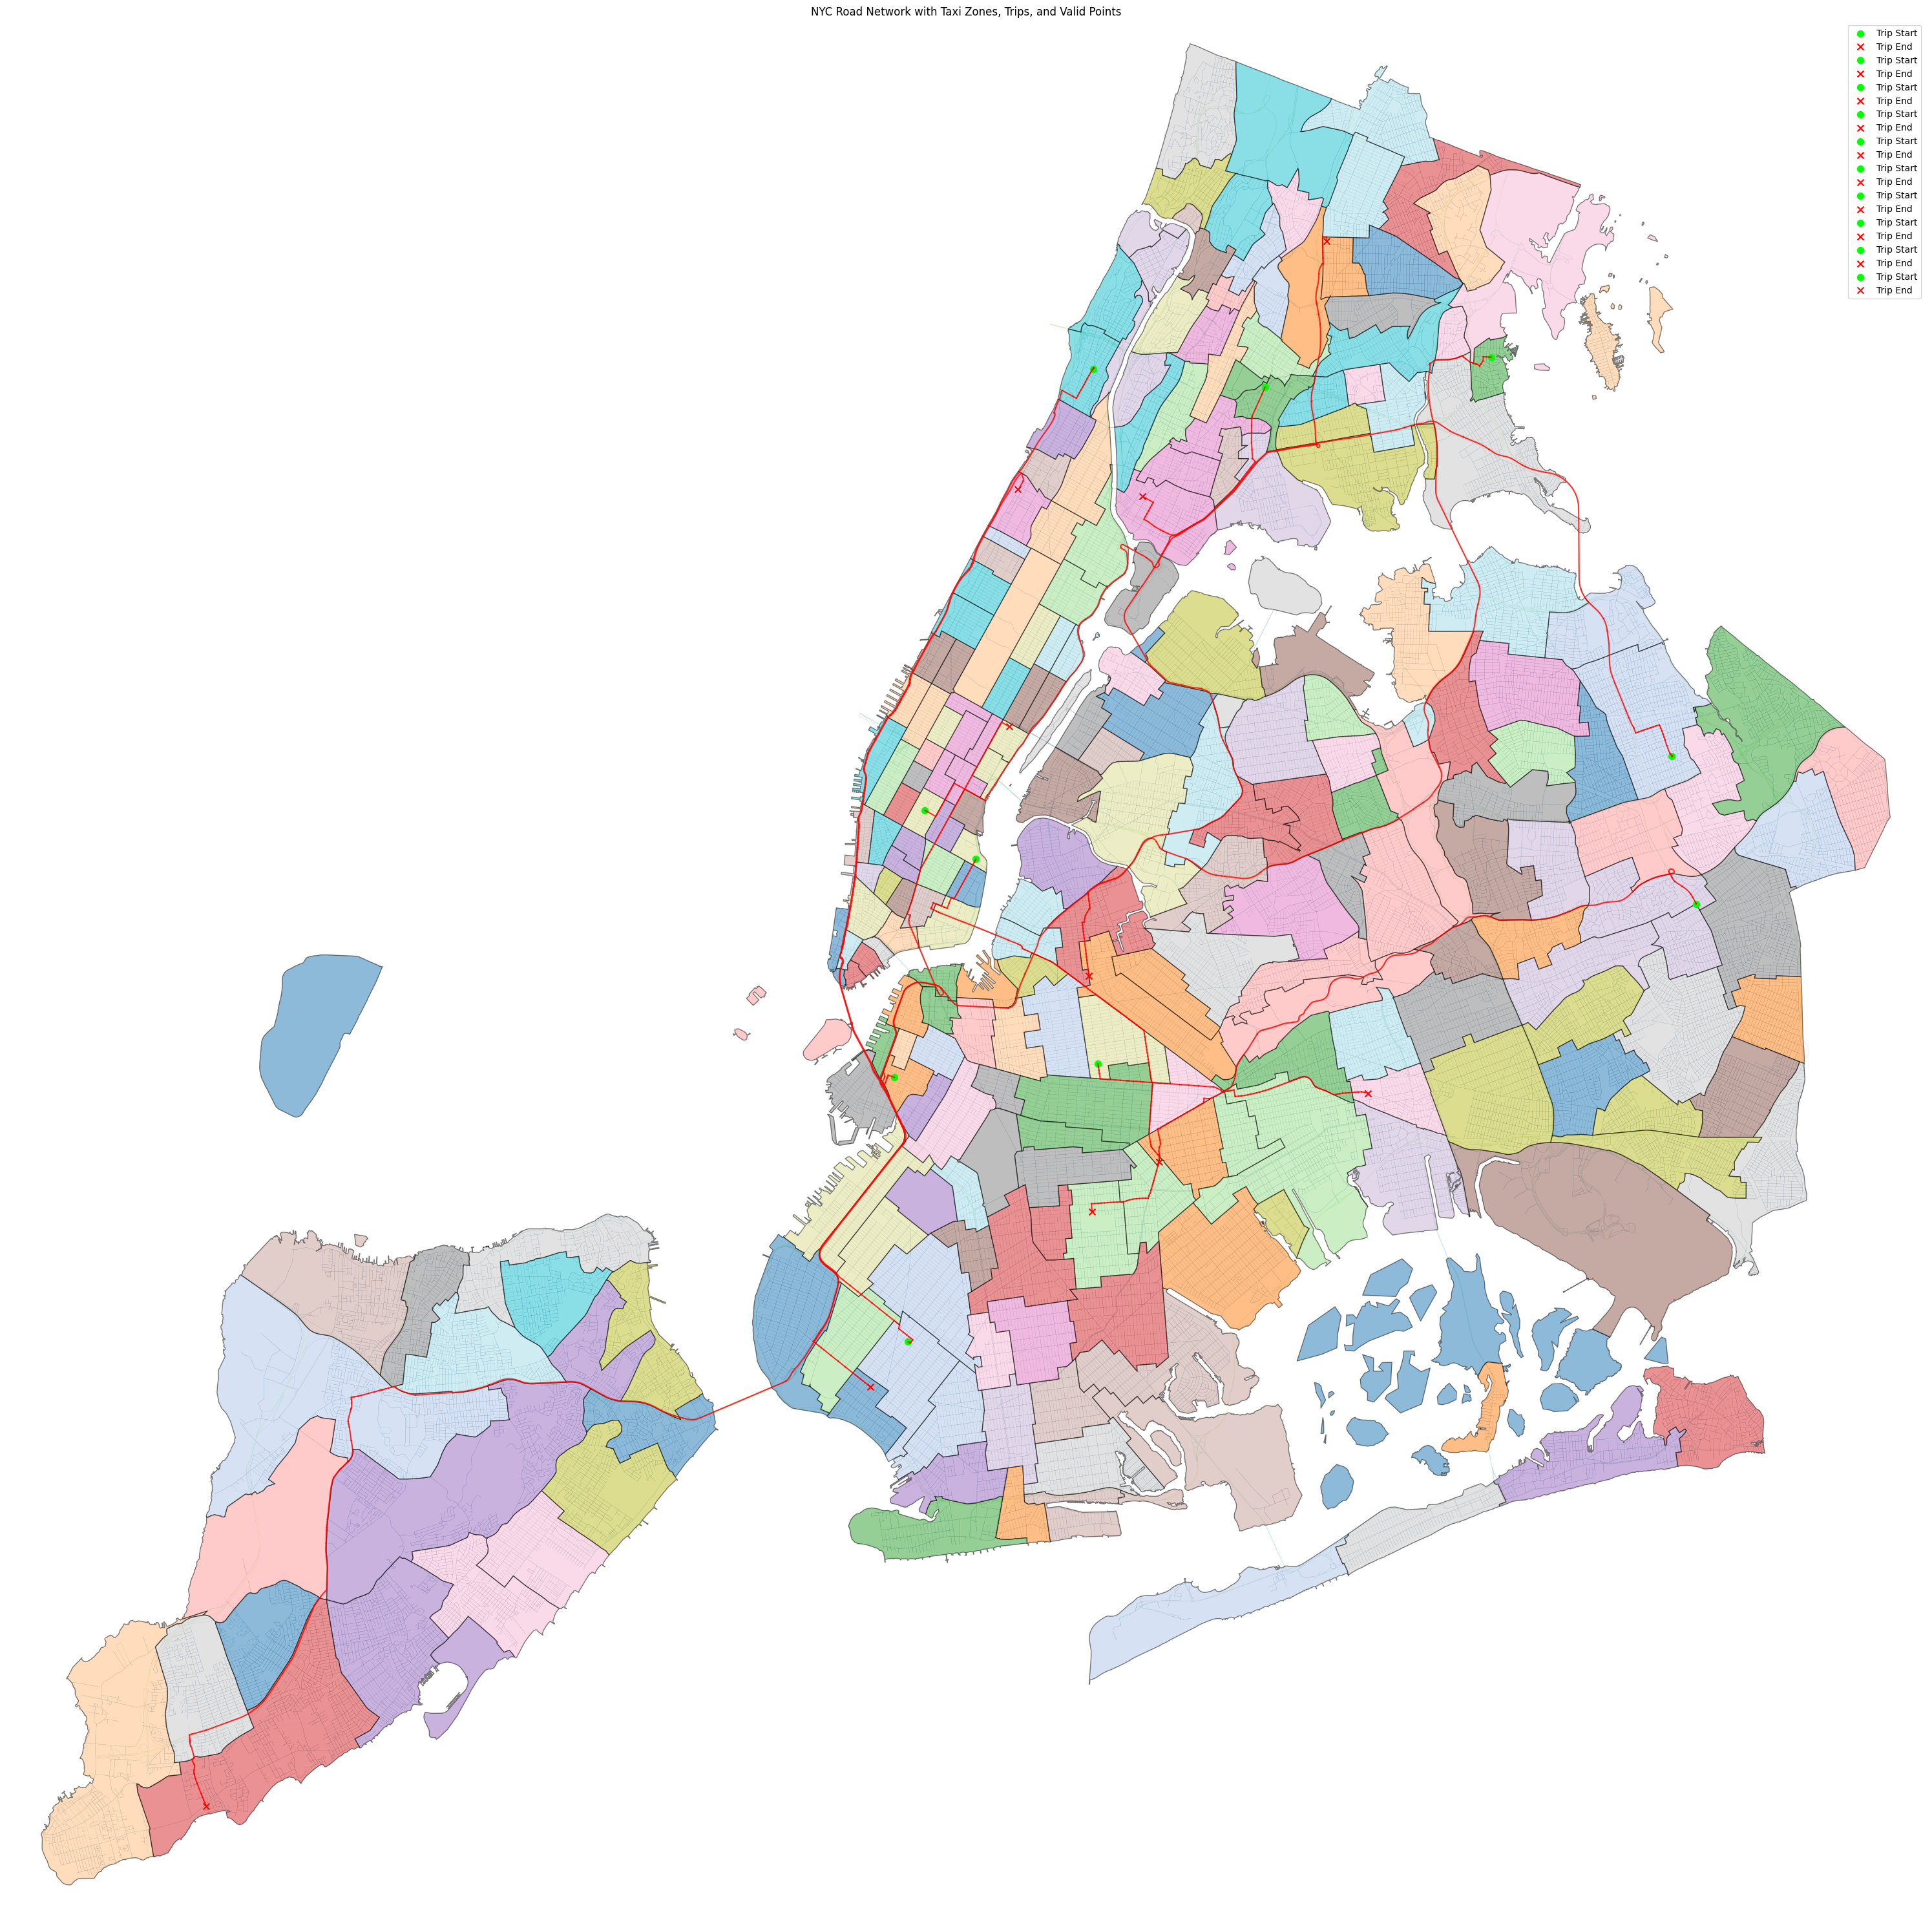

In [29]:
# Main function

USE_FAKE_CITY = False

if USE_FAKE_CITY:
    print("WARNING - fake city generation has not been modified to work with the new intra-zone prediction code")
    zones, street_graph, trips, width, height = generate_synthetic_city_data() # type: ignore
    visualise(street_graph, zones, width, height, trips=trips) # type: ignore
else:
    zones, street_graph, trips = generate_real_city_data() # type: ignore
    print("Visualising real city...")
    display_real_city(street_graph, zones, trips) # type: ignore

In [30]:
# IGraph might be faster?
CONVERT_TO_IGRAPH = False

if CONVERT_TO_IGRAPH:
    i_street_graph = ig.Graph(directed=True)
    print("Adding vertices...")

    node_id_map = {node: idx for idx, node in enumerate(street_graph.nodes())}

    i_street_graph.add_vertices(len(node_id_map))
    
    print("Adding edges...")
    edge_attributes = ['osmid', 'highway', 'lanes', 'maxspeed', 'name', 'oneway', 'ref', 'reversed', 'length', 'geometry', 'speed_kph', 'travel_time']
    for u, v, data in tqdm(street_graph.edges(data=True), desc="Adding edges"):
        i_street_graph.add_edge(node_id_map[u], node_id_map[v], **{attr: data.get(attr, None) for attr in edge_attributes})

    print("Adding attributes...")
    attributes = ['y', 'x', 'highway', 'ref', 'street_count', 'zone']
    for attr in attributes:
        i_street_graph.vs[attr] = [street_graph.nodes[node].get(attr, None) for node in street_graph.nodes()]

In [103]:
# Find the nodes that are on the "edge" of a zone
# These are nodes which are in a zone but have at least one neighbour that is not in the zone
def find_edge_nodes(street_graph):
    edge_nodes_lookup = {}
    
    points_by_zone = get_points_by_zone(street_graph) # type: ignore
    
    for zone_id, points in points_by_zone.items():
        edge_nodes = set()
        for point in points:
            neighbours = list(street_graph.neighbors(point))
            for neighbour in neighbours:
                if street_graph.nodes[neighbour]["zone"] != zone_id:
                    edge_nodes.add(point)
                    break
        edge_nodes_lookup[zone_id] = edge_nodes
    return edge_nodes_lookup

edge_nodes_lookup = find_edge_nodes(street_graph)

In [104]:

def trim_path_to_zone(G, path, start_zone_id, end_zone_id):
    while path and get_zone(G, path[0]) != start_zone_id:
        path.pop(0)
    
    while path and get_zone(G, path[-1]) != end_zone_id:
        path.pop()

    return path

def get_zone(G, node):
    return G.nodes[node].get("zone")

def compute_costs_from_node(G, node, target_nodes=None):
    if target_nodes is not None:
        distances = {}
        travel_times = {}
        for target in target_nodes:
            try:
                distances[target] = nx.dijkstra_path_length(G, node, target, weight='length')
                travel_times[target] = nx.dijkstra_path_length(G, node, target, weight='travel_time')
            except nx.NetworkXNoPath:
                distances[target] = float('inf')
                travel_times[target] = float('inf')
    else:
        distances, _ = nx.single_source_dijkstra(G, node, weight='length')
        travel_times, _ = nx.single_source_dijkstra(G, node, weight='travel_time')
    
    return distances, travel_times

def get_valid_area_fast(G, trip, print_debug=False):
    start_edge_nodes = edge_nodes_lookup[trip["start_zone_id"]]
    end_edge_nodes = edge_nodes_lookup[trip["end_zone_id"]]
    
    # Keep picking new start and end nodes until we find a pair that gives us non-negative budgets
    print("Finding start and end nodes...")
    while True:
        start_node = random.choice(list(start_edge_nodes))
        end_node = random.choice(list(end_edge_nodes))
        
        if print_debug:
            print("Trying pair:", start_node, end_node)
        
        try:
            path = nx.shortest_path(G, source=start_node, target=end_node, weight='travel_time')
        except nx.NetworkXNoPath:
            if print_debug:
                print(f"No path found between {start_node} and {end_node}. Retrying...")
            continue
        
        # Compute distance and time budget (difference between original and our inter-zone path)
        distance_budget = trip["distance"] - nx.path_weight(G, path, weight='length')
        time_budget = trip["travel_time"] - nx.path_weight(G, path, weight='travel_time')
        
        if distance_budget > 0 and time_budget > 0:
            break
    
    # Get start and end nodes in respective zones
    start_nodes = {n for n, d in G.nodes(data=True) if d.get("zone") == trip["start_zone_id"]}
    end_nodes = {n for n, d in G.nodes(data=True) if d.get("zone") == trip["end_zone_id"]}
    
    # Get costs to travel from the start to any other node in the start zone and vice versa for the end zone
    if print_debug:
        print("Computing costs from start and end nodes...")
    start_distances, start_travel_times = compute_costs_from_node(G, path[0], target_nodes=start_nodes)
    end_distances, end_travel_times = compute_costs_from_node(G, path[-1], target_nodes=end_nodes)
    
    valid_start_nodes = set()
    valid_end_nodes = set()
    
    if print_debug:
        print(f"Original costs: {trip['distance']} m, {trip['travel_time']} s")
        print(f"Inter-zone costs: {nx.path_weight(G, path, weight='length')} m, {nx.path_weight(G, path, weight='travel_time')} s")
        print(f"Remaining budgets: {distance_budget} m, {time_budget} s")
    
    best_remaining_distance = float('inf')
    best_remaining_time = float('inf')

    # Check if any valid start node can reach any valid end node within the distance and time budget
    print("Filtering valid start and end nodes...")
    for start_node in start_nodes:
        # Compute budget remaining that the end node must satisfy
        distance_budget_for_end = distance_budget - start_distances[start_node]
        time_budget_for_end = time_budget - start_travel_times[start_node]
        
        if distance_budget_for_end <= 0 or time_budget_for_end <= 0:
            continue
        
        for end_node in end_nodes:
            # Compute residual budgets
            distance_residual_budget = distance_budget_for_end - end_distances[end_node]
            time_residual_budget = time_budget_for_end - end_travel_times[end_node]
            
            if 0 < distance_residual_budget <= 0.1 * trip["distance"] and 0 < time_residual_budget <= 0.1 * trip["travel_time"]:
                valid_start_nodes.add(start_node)
                valid_end_nodes.add(end_node)
            
            if print_debug:
                if abs(distance_residual_budget) < abs(best_remaining_distance):
                    best_remaining_distance = distance_residual_budget
                if abs(time_residual_budget) < abs(best_remaining_time):
                    best_remaining_time = time_residual_budget
    
    if print_debug:
        print(f"Best remaining distance: {best_remaining_distance} m")
        print(f"Best remaining time: {best_remaining_time} s")

    fraction_start_nodes_valid = len(valid_start_nodes) / len(start_nodes) if start_nodes else 0
    fraction_end_nodes_valid = len(valid_end_nodes) / len(end_nodes) if end_nodes else 0

    return valid_start_nodes, valid_end_nodes, fraction_start_nodes_valid, fraction_end_nodes_valid


In [105]:
total_time = 0
valid_start_points_list = []
valid_end_points_list = []

for trip in tqdm(trips, desc="Processing trips"):
    start_time = time.time()
    valid_start_points, valid_end_points, _, _ = get_valid_area_fast(street_graph, trip, print_debug=False)
    end_time = time.time()
    
    total_time += (end_time - start_time)
    valid_start_points_list.append(valid_start_points)
    valid_end_points_list.append(valid_end_points)

average_time = total_time / len(trips)
print(f"Average computation time: {average_time} seconds")

if False:
    display_real_city(street_graph, zones=zones, trips=[single_trip], valid_points={ # type: ignore
        "valid_start": valid_start_points,
        "valid_end": valid_end_points,
    })

Processing trips:   0%|          | 0/8 [00:00<?, ?it/s]

Finding start and end nodes...


Processing trips:  12%|█▎        | 1/8 [00:01<00:13,  1.96s/it]

Filtering valid start and end nodes...
Finding start and end nodes...


Processing trips:  25%|██▌       | 2/8 [00:05<00:18,  3.14s/it]

Filtering valid start and end nodes...
Finding start and end nodes...


Processing trips:  38%|███▊      | 3/8 [00:11<00:21,  4.24s/it]

Filtering valid start and end nodes...
Finding start and end nodes...


Processing trips:  50%|█████     | 4/8 [00:14<00:15,  3.76s/it]

Filtering valid start and end nodes...
Finding start and end nodes...


Processing trips:  62%|██████▎   | 5/8 [00:15<00:08,  2.82s/it]

Filtering valid start and end nodes...
Finding start and end nodes...


Processing trips:  75%|███████▌  | 6/8 [00:15<00:03,  1.96s/it]

Filtering valid start and end nodes...
Finding start and end nodes...


Processing trips:  88%|████████▊ | 7/8 [00:21<00:03,  3.08s/it]

Filtering valid start and end nodes...
Finding start and end nodes...


Processing trips: 100%|██████████| 8/8 [00:22<00:00,  2.79s/it]

Filtering valid start and end nodes...
Average computation time: 2.7943795919418335 seconds
